# OilyGiant - Project

## Introduction

In this project I will be working with data from OilyGiant. The data I have will be on the oil samples from 3 regions. The goal of this project is to find the well with the best parameters that would lead to the highest profit margin. For this project, I will be going through steps:

   1. [Data Overview and Preprocessing](#data_overview)
   2. [Model Training and Testing](#model_training)
   3. Profit Calculation
   4. Presenting findings and Conclusion


<a id='data_overview'></a>
## Data Overview and Preprocessing


In [1]:
## Importing the necessary libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils import shuffle, resample
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Pulling the dataset

df1 = pd.read_csv('/datasets/geo_data_0.csv')
df2 = pd.read_csv('/datasets/geo_data_1.csv')
df3 = pd.read_csv('/datasets/geo_data_2.csv')
regions = ['region_1', 'region_2', 'region_3']

print("Region 1 Info:")
print()
df1.info()
print()
print("Region 2 Info:")
print()
df2.info()
print()
print("Region 3 Info:")
print()
df3.info()

Region 1 Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Region 2 Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Region 3 Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data 

In [3]:
df1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
df2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [5]:
df3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


The datasets look good and there seems to be no obvious problems. The ID column however doesn't seem to show any use in future applications for training the models, so I'll discard it later.

In [6]:
# Checking for duplicates

df1.duplicated().sum()

0

In [7]:
df2.duplicated().sum()

0

In [8]:
df3.duplicated().sum()

0

There also seems to be no duplicates found. The data is perfect and is ready to be worked on.

### Getting the necessary variables

In [9]:
df1_statistics = df1['product'].describe().round(3).to_frame()
df2_statistics = df2['product'].describe().round(3).to_frame()
df3_statistics = df3['product'].describe().round(3).to_frame()

statistics = pd.concat([df1_statistics, df2_statistics, df3_statistics], axis=1, ignore_index=True)
statistics.columns = regions
statistics

,region_1,region_2,region_3
count,100000.000,100000.000,100000.000
mean,92.500,68.825,95.000
std,44.289,45.944,44.750
min,0.000,0.000,0.000
25%,56.498,26.953,59.450
50%,91.850,57.086,94.926
75%,128.564,107.813,130.595
max,185.364,137.945,190.030


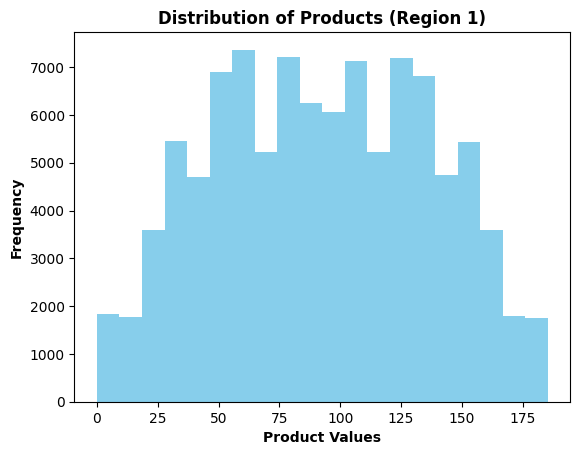

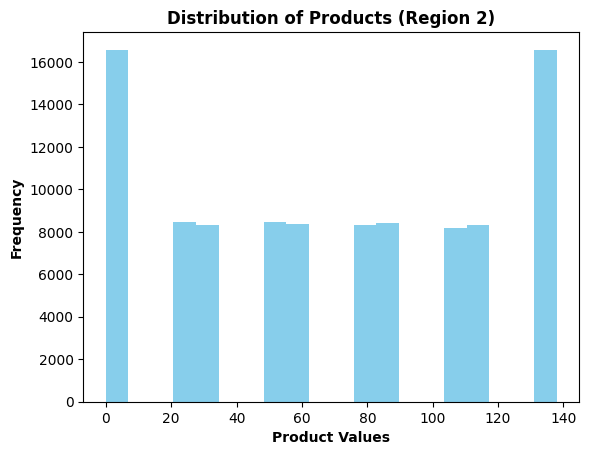

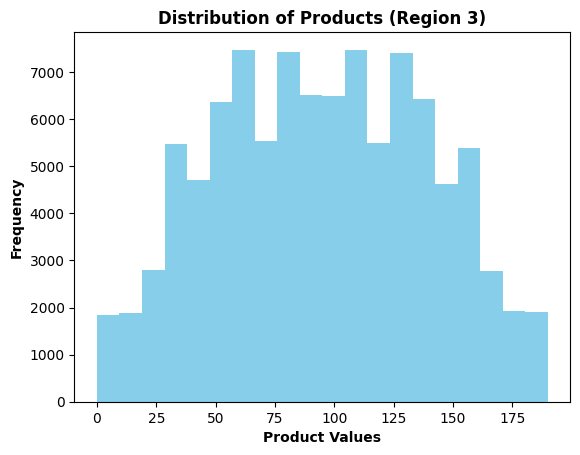

In [10]:
# Visualizing the distribution of products from each region

for i, region in enumerate([df1, df2, df3]):
    plt.hist(
        region['product'],
        bins=20,
        color='skyblue',
        )

    plt.xlabel('Product Values', fontdict={'weight':'bold'})
    plt.ylabel('Frequency', fontdict={'weight':'bold'})
    plt.title(f"Distribution of Products (Region {i+1})", fontdict={'weight':'bold', 'size':12})
    plt.show()

From the statistics we can see that the values look pretty evenly distributed, with the 2nd region being the exception. It seems that region 3 has the highest volume of reserves, having over 190k barrels. Region 2 has a much lower reserves compared to the other 2 regions, with only 138k barrels of oil, as well as seemingly an uneven distribution.

<a id='model_training'></a>
## Model Training and Testing

As recommended, I will only be using Linear Regression as the model and adjust it to the required needs of the task. I will also start making the features and target columns as well as splitting the dataset to the training and valid sets respectively.

In [11]:
# Getting the features and target columns
feature_columns = ['f0', 'f1', 'f2']
target_columns = ['product']
datasets = [df1, df2, df3]

# Creating a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('regressor', LinearRegression(n_jobs=-1))
])

predicted_df = pd.DataFrame()
predicted_df_statistics = pd.DataFrame(columns=["region", "actual_average_product_vol", "predicted_average_product_vol", "baseline_RMSE", "predicted_RMSE"])


x = 1
for i, frame in enumerate(datasets):
    column_name = f'predicted_{i+1}'
    features = frame[feature_columns]
    target = frame[target_columns]
    
    x_train, x_val, y_train, y_val = train_test_split(
    features, target, test_size=.25, random_state=123)
    
    # Getting the baseline for comparison
    base_model = DummyRegressor(strategy='mean')
    base_model.fit(x_train, y_train)
    base_pred = base_model.predict(x_val)
    baseline_rmse = np.sqrt(mean_squared_error(y_val, base_pred))
    
    # Training the LinearRegression Model
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_val)
    mean_product = y_pred.mean()
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    
    region = f"Region {x}"
    predicted_df[column_name] = pd.Series(y_pred.flatten().round(2)) 
    
    actual = f'actual_{x}'
    predicted_df[actual] = y_val.reset_index(drop=True).round(2)
    x += 1
    
    
    # Getting the rows for statistics
    row = {
        "region": region,
        "actual_average_product_vol": frame[target_columns].mean().round(2).item(),
        "predicted_average_product_vol": mean_product.round(2), 
        "predicted_RMSE": rmse.round(3),
        "baseline_RMSE": baseline_rmse.round(3)
    }
    predicted_df_statistics = predicted_df_statistics.append(row, ignore_index=True)
    


In [12]:
predicted_df.head()

,predicted_1,actual_1,predicted_2,actual_2,predicted_3,actual_3
0,123.35,145.83,56.05,57.09,109.62,147.45
1,75.61,134.02,81.58,80.86,113.84,128.71
2,55.63,88.91,54.45,53.91,91.73,106.63
3,86.50,19.51,108.65,107.81,136.59,128.79
4,109.81,108.71,54.48,53.91,91.20,159.33


In [13]:
# Splitting the data into the respective regions

regions_data = {}

for i in range(3):
    regions_data[f'region_{i+1}'] = predicted_df[[f'predicted_{i+1}', f'actual_{i+1}']]
    regions_data[f'region_{i+1}'].columns = ['predicted_volume', 'actual_volume']

In [14]:
for r in regions_data:
    print(f"Table of {r}'s data")
    display(regions_data[r].head())
    print(regions_data[r].shape)
    print()
    print('*'*35)
    print()

Table of region_1's data


,predicted_volume,actual_volume
0,123.35,145.83
1,75.61,134.02
2,55.63,88.91
3,86.50,19.51
4,109.81,108.71


(25000, 2)

***********************************

Table of region_2's data


,predicted_volume,actual_volume
0,56.05,57.09
1,81.58,80.86
2,54.45,53.91
3,108.65,107.81
4,54.48,53.91


(25000, 2)

***********************************

Table of region_3's data


,predicted_volume,actual_volume
0,109.62,147.45
1,113.84,128.71
2,91.73,106.63
3,136.59,128.79
4,91.20,159.33


(25000, 2)

***********************************



In [15]:
predicted_df_statistics

,region,actual_average_product_vol,predicted_average_product_vol,baseline_RMSE,predicted_RMSE
0,Region 1,92.50,92.55,44.411,37.648
1,Region 2,68.83,69.28,45.823,0.895
2,Region 3,95.00,95.14,44.674,38.864


It seems that the RMSE for all 3 regions are lower than the baseline. The model for Region 2 seems to be the most accurate one from the 3 as it ahs the lowest value of RMSE, which shows reliabilty in the data for having low deviation and high accuracy of the predicted scores. Although the RMSE from the other 2 regions are low, they're still pretty accurate in the average product volumes, which could still be useful when trying to calculate profits from a huge number of wells.

## Profit Calculation and Risk Assesment

In [16]:
# Storing key values

budget = 100000000
unit_revenue = 4500
wells = 200
barrel_revenue = 4.5
max_risk = 0.025
state = np.random.RandomState(123)

# Creating a formula for profit calculation

def calc_profit(frame):
    
    return frame.sort_values(by='predicted_volume', ascending=False).iloc[:wells]['actual_volume'].sum() * unit_revenue - budget


In [17]:
# Getting the minimum oil reserves per well
min_volume_per_well = budget / wells / unit_revenue

print(f'The minimum volume of reserves per oil well without losses: {min_volume_per_well:.2f} \n')

print("The predicted volume of oil reserves per region:")
print("Region 1: ", predicted_df_statistics['predicted_average_product_vol'].loc[0])
print("Region 2: ", predicted_df_statistics['predicted_average_product_vol'].loc[1])
print("Region 3: ", predicted_df_statistics['predicted_average_product_vol'].loc[2])

The minimum volume of reserves per oil well without losses: 111.11 

The predicted volume of oil reserves per region:
Region 1:  92.55
Region 2:  69.28
Region 3:  95.14


The minimum reserves per oil well is 111.11. From the looks of the average reserves in all the regions, the company won't earn a profit if they were to choose any random 200 oil wells. We can however use the model to take the top potential wells with the highest volume of reserves as well as calculate their profitability.

In [18]:
# Getting the top wells based on the predicted values
    
print("Profits from the top 200 wells of each region:\n")
profits = {} # Initializing the dictionary for the profits
for i, r in enumerate(regions): 
    
    data = regions_data[r]
    
    # Calculating the profits by getting total revenue and subtracting the budget to it
    profits[f'profit_{i+1}'] = (calc_profit(data) / 1000000).round(2)
    print(f"The profit for {r}: ${profits[f'profit_{i+1}']} million")

Profits from the top 200 wells of each region:

The profit for region_1: $35.38 million
The profit for region_2: $24.16 million
The profit for region_3: $24.95 million


From the results we can see that region 1 has the highest potential profit when we choose the top 200 wells from each region. Next I will be making extra samples using the bootstrapping technique to assess the profitability and risks.

In [19]:
# Number of total samples and random state value
total_samples = 1000
state = np.random.RandomState(234)

# Dictionaries to store profits and calculation result
sample_profits = {}


# Initiating the Bootstrapping technique
for r in regions:
    sample_profits[r] = [] # List to store the profits of 1000 samples for each region
    
    for i in range(total_samples):
        # Getting the 500 points of study for the samples
        sample = (regions_data[r]).sample(n=500, replace=True, random_state=state).reset_index(drop=True)
        
        # Recalculating the top 200 wells through the samples and putting them together
        sample_profits[r].append(calc_profit(sample))
        
    sample_profits[r] = pd.Series(sample_profits[r])
    profit_mean = np.mean(sample_profits[r])
    negative_profit = sample_profits[r] < 0
    confidence_interval = ((sample_profits[r].quantile(0.025) / 1000000).round(2), (sample_profits[r].quantile(0.975) / 1000000).round(2))
    
    # Printing the results of the assessment
    
    print(f"--{r}--")
    print(f"Mean profit of the region = ${(profit_mean / 1000000).round(2)} Million")
    print("95% Confidence Interval: ", confidence_interval)
    print(f"Risk of losses: {sum(negative_profit) / len(sample_profits[r])}%")
    print()

--region_1--
Mean profit of the region = $4.86 Million
95% Confidence Interval:  (-0.13, 10.08)
Risk of losses: 0.032%

--region_2--
Mean profit of the region = $4.62 Million
95% Confidence Interval:  (0.9, 8.6)
Risk of losses: 0.008%

--region_3--
Mean profit of the region = $5.39 Million
95% Confidence Interval:  (0.05, 10.27)
Risk of losses: 0.024%



The results of bootstrapping the values shows that there are very minimal risks when it comes to taking the top 200 wells of all 3 regions. Region 3 boasts the highest amount of profit across all 3 regions, however  region 2 has the lowest amount of risk of losses, and a much higher value on the lower confidence interval. Region 1 has the highest amount of risk of losses as well as it's bottom confidence interval is below 0, which doesn't make it a good choice.

## Conclusion

Through the processing of the data, we were able to gather the statistics for each region. These, when combined with the model created for predicting the values of each region, allowed us to see the just how profitable the wells are. The initial preprocessing shows that the data was well prepared, without any missing and/or duplicate values. With the exception of the index column, the model training was able to commence almost immediately. 

Across all regions, region 3 has the highest volume of reserves across all three, followed by 1 and finally 2. Through the predictions from the model however, it shows that region 3 also has the highest RMSE, which means the values from the features weren't exactly too accurate in making the predictions, and the predicted values also has a high deviation, leading to potentially unreliable results. 

After calculating the revenue using the formula we can see that we need at least 111 volume of reserves to make a profit from selecting 200 random wells from each region, however the prediction shows that the average number of reserves from each region only goes up to ~90, which means we can't really take any random 200 wells and expect profits from it. From there we rely on the model predictions to find the top 200 wells from each region instead and see how much of a profit can we actually make. Initial assesments show over 20 million USD in profits if we were to choose the top 200 wells from each region, with region 1 being the most profitable from all 3 regions. We have to make sure one last time using the bootstrapping technique to obtain the mean profit from each region. The result shows that region 3 has the highest amount of all 3 with an average of over 5 million USD, however it also has the 2nd highest risk of losses after region 1. Region 2, while having the smaller average profit of 4.6 million USD, has the lowest risk of losses as well as a much higher bottom confidence interval across all 3 regions.